# Module import

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets

# Device check

In [36]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version :', torch.__version__, ' Device :', DEVICE)

Using PyTorch version : 1.7.0+cu101  Device : cuda


# Hyper parameter

In [37]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


config = Config({
    'batch_size' : 32,
    'epochs': 10,
    'learning_rate': 0.001
})

# Data download

In [38]:
train_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                                     train = True,
                                     download = True,
                                     transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = config.batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = config.batch_size,
                                          shuffle = False)

# Data 확인하기

In [39]:
for X_train, Y_train in train_loader:
    print('X_train :', X_train.size(), 'type :', X_train.type())
    print('Y_train :', Y_train.size(), 'type :', Y_train.type())
    break

X_train : torch.Size([32, 1, 28, 28]) type : torch.FloatTensor
Y_train : torch.Size([32]) type : torch.LongTensor


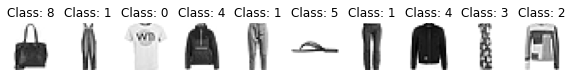

In [40]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class: '+str(Y_train[i].item()))

# AE 모델 설계

In [41]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 손실함수와 Optimizer 설정

In [42]:
model = AE().to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


# 학습하는 함수 정의

In [43]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28*28).to(DEVICE)
        target = image.view(-1, 28*28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = loss_func(decoded, target)
        loss.backward()
        optimizer.step()

# 검증 함수 정의

In [44]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE)
            target = image.view(-1, 28*28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += loss_func(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to('cpu'))

    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

# 학습 실행


[EPOCH : 1], 	Test Loss : 0.0005


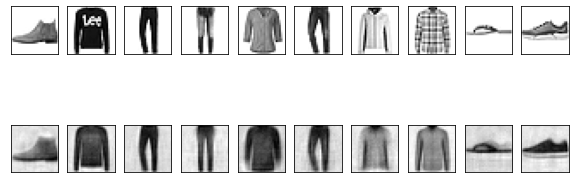


[EPOCH : 2], 	Test Loss : 0.0004


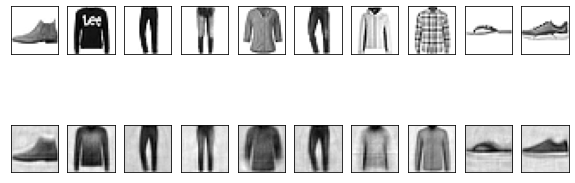


[EPOCH : 3], 	Test Loss : 0.0004


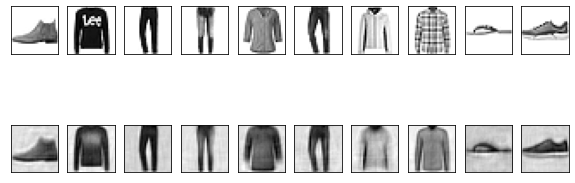


[EPOCH : 4], 	Test Loss : 0.0003


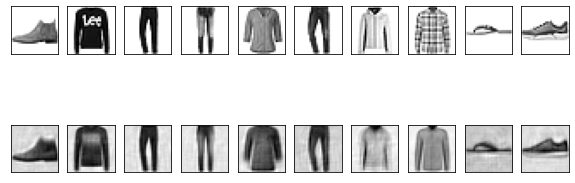


[EPOCH : 5], 	Test Loss : 0.0003


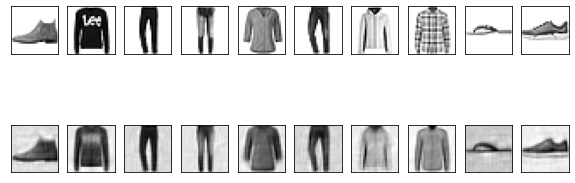


[EPOCH : 6], 	Test Loss : 0.0003


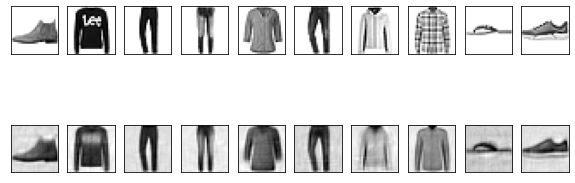


[EPOCH : 7], 	Test Loss : 0.0003


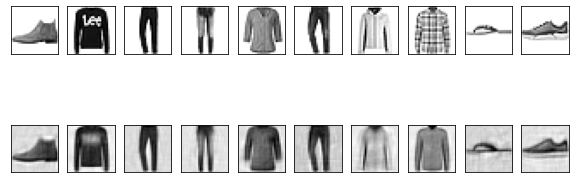


[EPOCH : 8], 	Test Loss : 0.0003


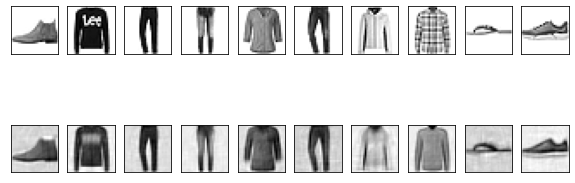


[EPOCH : 9], 	Test Loss : 0.0003


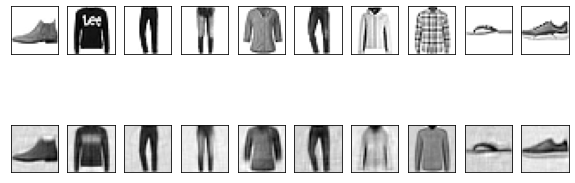


[EPOCH : 10], 	Test Loss : 0.0003


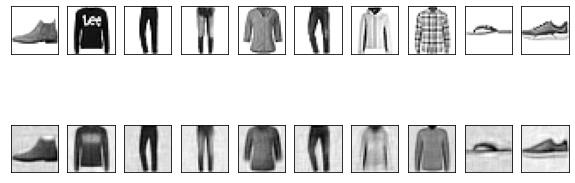

In [45]:
test_loss_arr = []
for Epoch in range(1, config.epochs+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    
    print()
    print("[EPOCH : {}], \tTest Loss : {:.4f}".format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap="gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap="gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()
    test_loss_arr.append(test_loss)

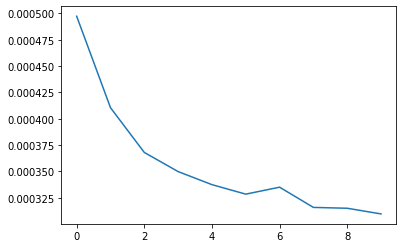

In [47]:
plt.plot(test_loss_arr)
plt.show()